In [1]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
from scipy.sparse import csr_matrix
from matplotlib.colors import Colormap

### Data Processing

In [2]:
df = pd.read_csv('movie&actor.csv')
movies = df['Movie'].tolist()
actors = df['Name'].tolist()

In [3]:
# filtering dataset

count = {}
for m, a in zip(movies, actors):
    if a not in count:
        count[a] = 0
    count[a] += 1
    
remove = list(count.items())
toremove = []
for name, c in remove:
    if c < 5:
        toremove.append(name)
    else:
        print(name)
        
newmovies = []
newactors = []
for m, a in zip(movies, actors):
    if a in toremove:
        continue
    newmovies.append(m)
    newactors.append(a)
actors = newactors
movies = newmovies

Adam Sandler
Jared Sandler
Jackie Sandler
Robbie Amell
Jesse Plemons
Lakeith Stanfield
Jacki Weaver
Andrew Bachelor
Fred Hechinger


In [4]:
# creating index for each node

d = {}
i = 0
for name in set(movies):
    d[name] = i
    i += 1
for actor in set(actors):
    if actor not in d:
        d[actor] = i
    i += 1

### Matrix Creation

In [5]:
l = []
for i, n in enumerate(list(d.keys())):
    if i < len(set(movies)):
        l.append([n, 'c0'])
    else:
        l.append([n,'c1'])
l = pd.DataFrame(l, columns=['name', 'cat'])
l.cat=l.cat.astype('category')
nodes = circular_layout(l, uniform=False)

In [6]:
edges = []
for movie,actor  in zip(movies, actors):
    edges.append([d[movie], d[actor]])
edges = pd.DataFrame(edges, columns=['source', 'target'])

### Function Invocation

In [7]:
cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=5, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(np, ep, how="over", name=name)

In [8]:
X=[]
Y=[]
m_len = len(set(movies))
a_len = len(set(actors))
total = m_len+a_len
for i in range(0,m_len):
    X.append(0.25)
    Y.append(i/m_len)
for i in range(m_len, total):
    X.append(0.75)
    Y.append((i-m_len)/a_len)
nodes['x']=X
nodes['y']=Y

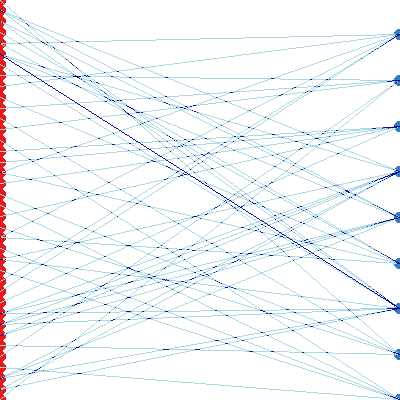

In [9]:
g = graphplot(nodes, connect_edges(nodes,edges), "Force-directed, bundled", cat="cat")
tf.Image(g)

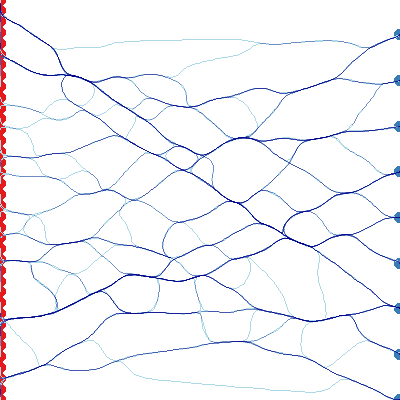

In [10]:
g = graphplot(nodes, hammer_bundle(nodes,edges, initial_bandwidth=0.05), "Force-directed, bundled", cat="cat")
img = tf.Image(g)
img

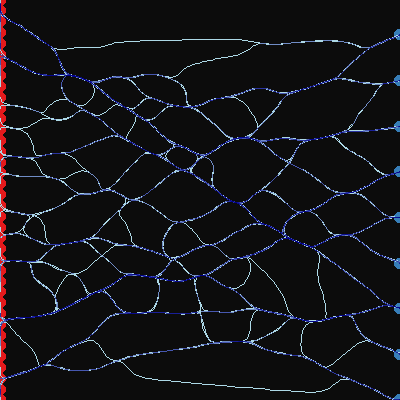

In [11]:
import datashader.composite as ops
darkgrey = np.uint32(0xff0c0c0c)
tf.Image(ops.source(img, darkgrey))